In [1]:
import matplotlib.pyplot as pltt
import numpy as np
import matplotlib as mpl
from pprint import pprint as pp
import matplotlib.ticker as ticker


%matplotlib inline

In [2]:
import seaborn as sb
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

## Load data

In [3]:
train=pd.read_csv('train.csv', parse_dates = ['Dates'])
test=pd.read_csv('test.csv', parse_dates = ['Dates'])

In [4]:
train.shape

(878049, 9)

In [5]:
train.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [6]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [7]:
[pp(i) for i in sorted(train.Category.unique())]
print("No. of categories = {:d}".\
      format(len(train.Category.unique())))

'ARSON'
'ASSAULT'
'BAD CHECKS'
'BRIBERY'
'BURGLARY'
'DISORDERLY CONDUCT'
'DRIVING UNDER THE INFLUENCE'
'DRUG/NARCOTIC'
'DRUNKENNESS'
'EMBEZZLEMENT'
'EXTORTION'
'FAMILY OFFENSES'
'FORGERY/COUNTERFEITING'
'FRAUD'
'GAMBLING'
'KIDNAPPING'
'LARCENY/THEFT'
'LIQUOR LAWS'
'LOITERING'
'MISSING PERSON'
'NON-CRIMINAL'
'OTHER OFFENSES'
'PORNOGRAPHY/OBSCENE MAT'
'PROSTITUTION'
'RECOVERED VEHICLE'
'ROBBERY'
'RUNAWAY'
'SECONDARY CODES'
'SEX OFFENSES FORCIBLE'
'SEX OFFENSES NON FORCIBLE'
'STOLEN PROPERTY'
'SUICIDE'
'SUSPICIOUS OCC'
'TREA'
'TRESPASS'
'VANDALISM'
'VEHICLE THEFT'
'WARRANTS'
'WEAPON LAWS'
No. of categories = 39


## Convert categorical variables into numbers

http://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/

In [8]:
le=LabelEncoder()
category = le.fit_transform(train.Category)


In [9]:
def hist_plot(data,top=10):
    category = le.fit_transform(data)
    pp("Total length of category= {:d}".format(len(category)))

    unique, counts = np.unique(category, return_counts=True)
    pp("No. of category= {:d}".format(len(unique)))
    hist=np.asarray((unique, counts,counts*100.0/sum(counts))).T
    hist_order=hist[hist[:,2].argsort()[::-1]]
    df = pd.DataFrame({'category':hist_order[:,0].astype(np.int64),\
                   'Count':hist_order[:,1].astype(np.int64),'Percentage':hist_order[:,2]})
    
    plt.figure(figsize=(8,6))
    ax=sb.barplot(le.inverse_transform(df.category[:top]),df.Percentage[:top])
    _ = plt.setp(ax.get_xticklabels(), rotation=90)  # Rotate labels
    return le.inverse_transform(df.category[:top])



'Total length of category= 878049'
'No. of category= 39'


array(['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT',
       'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS',
       'BURGLARY', 'SUSPICIOUS OCC', 'MISSING PERSON', 'ROBBERY'], dtype=object)

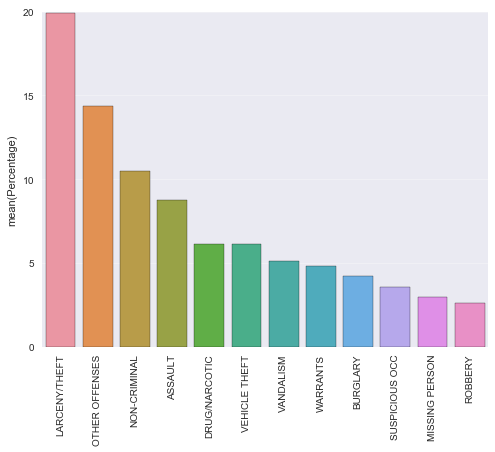

In [10]:
#Histogram of top 12 catagories and y-axis is in percentage. 
hist_plot(train.Category,12)

In [28]:
T_12=['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT',
       'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS',
       'BURGLARY', 'SUSPICIOUS OCC', 'MISSING PERSON', 'ROBBERY']

In [31]:
#for i in T_12:
#    hist_plot(train[train['Category']==i].DayOfWeek)

'Total length of category= 878049'
'No. of category= 10'


array(['SOUTHERN', 'MISSION', 'NORTHERN', 'BAYVIEW', 'CENTRAL',
       'TENDERLOIN', 'INGLESIDE', 'TARAVAL', 'PARK', 'RICHMOND'], dtype=object)

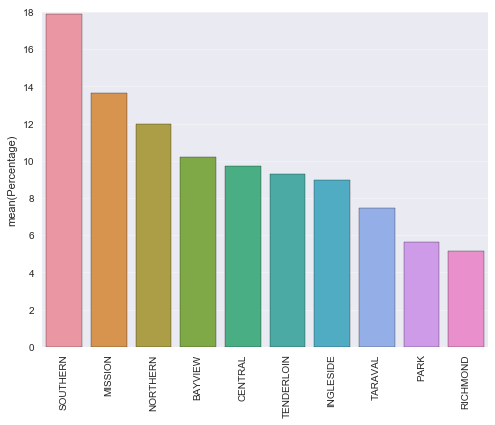

In [12]:
#Histogram for top 10 PdDistrict
hist_plot(train.PdDistrict)

'Total length of category= 878049'
'No. of category= 23228'


array(['800 Block of BRYANT ST', '800 Block of MARKET ST',
       '2000 Block of MISSION ST', '1000 Block of POTRERO AV',
       '900 Block of MARKET ST', '0 Block of TURK ST', '0 Block of 6TH ST',
       '300 Block of ELLIS ST', '400 Block of ELLIS ST',
       '16TH ST / MISSION ST', '1000 Block of MARKET ST',
       '1100 Block of MARKET ST', '2000 Block of MARKET ST',
       '100 Block of OFARRELL ST', '700 Block of MARKET ST'], dtype=object)

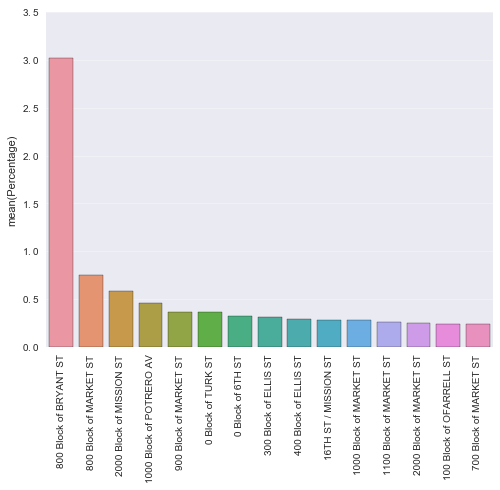

In [13]:
#Histogram with Address.
hist_plot(train.Address,15)

'Total length of category= 878049'
'No. of category= 24'


array([18, 17, 12, 16, 19, 15, 22,  0, 20, 14, 21, 13, 23, 11, 10,  9,  8,
        1,  2,  7,  3,  6,  4,  5])

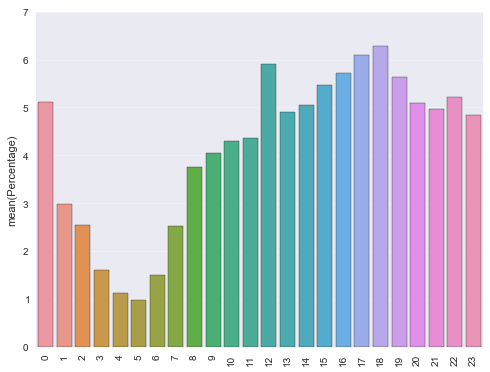

In [14]:
#Histogram with per hour.
hist_plot(train.Dates.dt.hour,24)

'Total length of category= 878049'
'No. of category= 12'


array([10,  5,  4,  3,  1, 11,  9,  6,  2,  7,  8, 12])

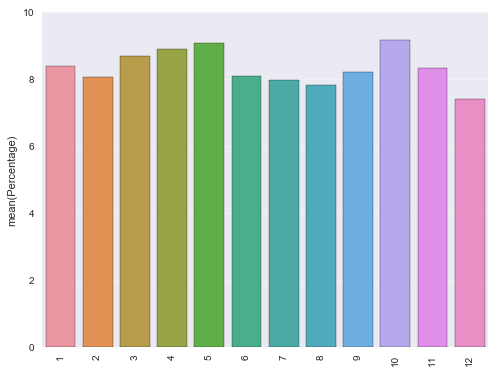

In [15]:
hist_plot(train.Dates.dt.month,13)

In [33]:
Top_10 = train[train['Category'].isin(train['Category']\
                                      .value_counts().head(10).index)]


In [279]:
day_hour=(pd.crosstab(train.Dates.dt.hour,train.DayOfWeek)).T

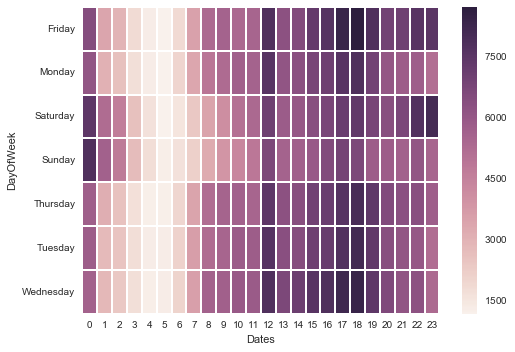

In [281]:
ax=sb.heatmap(day_hour,linewidths=1)
#ax.set(ylabel='Day of Week', xlabel='Hour')

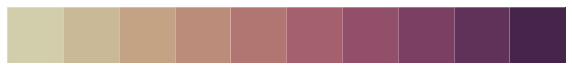

In [339]:
sb.palplot(sb.cubehelix_palette(10, start=3, rot=0.6,dark=0.2,light=.8))

In [19]:
def heat_map(data1,data2):
    data_cross=(pd.crosstab(data1,data2)).T
    data_cross=data_cross/data_cross.sum().sum()
    ax=sb.heatmap(data_cross,linewidth=1,cmap=sb.cubehelix_palette(10, start=3, rot=0.6, dark=0.2,light=.9, as_cmap=True))

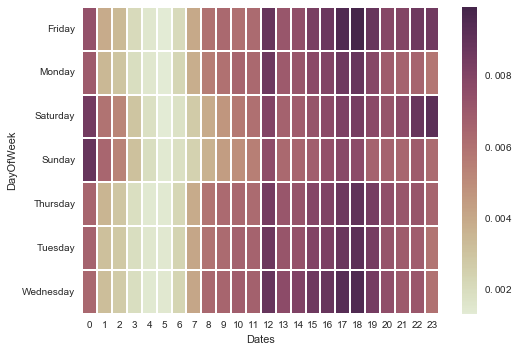

In [20]:
heat_map(train.Dates.dt.hour,train.DayOfWeek)

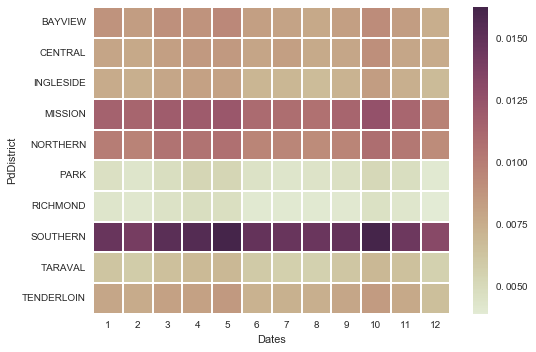

In [21]:
heat_map(train.Dates.dt.month,train.PdDistrict)

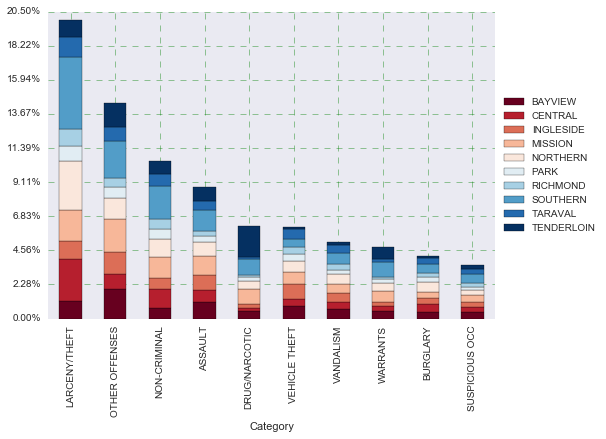

In [39]:
#I reordered the array so that it is in the ascending order.
cat_district=pd.crosstab(Top_10['Category'],Top_10['PdDistrict'])
ax=cat_district.ix[list(cat_district.sum(axis=1).sort_values(ascending=False).index)].plot(kind='bar',stacked=True,\
                  cmap='RdBu',grid=False,alpha=1)

vals = ax.get_yticks()
ax.set_yticklabels(['{:2.2f}%'.format(x*100/train.shape[0]) for x in vals])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True,color='g',alpha=0.4,linestyle='--')

In [35]:
cat_district=cat_district.ix[list(cat_district.sum(axis=1).sort_values(ascending=False).index)]

(0, 1)

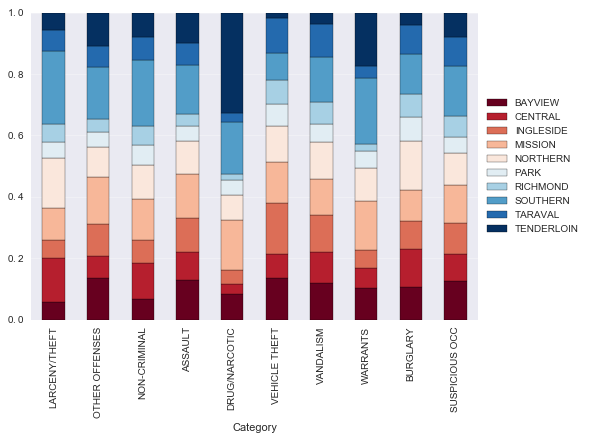

In [38]:
ax=cat_district.div(cat_district.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,cmap='RdBu')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0,1)